In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten, Conv2D, LeakyReLU

dfX = pd.read_csv('train_gesture_x.csv',header=None)
dfY = pd.read_csv('train_gesture_y.csv',header=None)
dfZ = pd.read_csv('train_gesture_z.csv',header=None)
dfLabels = pd.read_csv('train_label.csv',header=None)

2021-07-15 11:17:07.553189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-15 11:17:07.553227: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load 3D tensor
train_gesture = np.dstack((dfX, dfY, dfZ))
train_labels = dfLabels.values

# Split training / test --> 80/20
train_x, test_x, train_y, test_y = train_test_split(train_gesture, train_labels, test_size=.2, shuffle=True)

In [4]:
def scale(trainX, testX, scale_type):
    if scale_type == "STANDARD":

        scalers = {}
        for i in range(trainX.shape[1]):
            scalers[i] = StandardScaler()
            trainX[:, i, :] = scalers[i].fit_transform(trainX[:, i, :])

        if testX is not None:
            for i in range(testX.shape[1]):
                testX[:, i, :] = scalers[i].transform(testX[:, i, :])


    if scale_type == "MINMAX":

        scalers = {}
        for i in range(trainX.shape[1]):
            scalers[i] = MinMaxScaler(feature_range=(-1, 1))
            trainX[:, i, :] = scalers[i].fit_transform(trainX[:, i, :])

        if testX is not None:
            for i in range(testX.shape[1]):
                testX[:, i, :] = scalers[i].transform(testX[:, i, :])

    if scale_type == "MAX_ABS":

        scalers = {}
        for i in range(trainX.shape[1]):
            scalers[i] = MaxAbsScaler()
            trainX[:, i, :] = scalers[i].fit_transform(trainX[:, i, :])

        if testX is not None:
            for i in range(testX.shape[1]):
                testX[:, i, :] = scalers[i].transform(testX[:, i, :])

    if scale_type == "ROBUST":

        scalers = {}
        for i in range(trainX.shape[1]):
            scalers[i] = RobustScaler(quantile_range=(25, 75), with_centering=False)
            trainX[:, i, :] = scalers[i].fit_transform(trainX[:, i, :])

        if testX is not None:
            for i in range(testX.shape[1]):
                testX[:, i, :] = scalers[i].transform(testX[:, i, :])

    return trainX, testX

In [5]:
scale_type = "ROBUST"
# scaling con scaler di tipo "scale_type"
train_x, test_x = scale(train_x, test_x, scale_type)

# one-hot encoding
train_y = tf.keras.utils.to_categorical(train_y, 8, dtype='float64')
test_y = tf.keras.utils.to_categorical(test_y, 8, dtype='float64')

In [8]:
def my_fit(datasetX, datasetY, testX, testY):

    n_timesteps, n_features, n_outputs = datasetX.shape[1], datasetX.shape[2], datasetY.shape[1]


    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=(n_timesteps, n_features),
                     kernel_regularizer=tf.keras.regularizers.l2(1.e-2)))
    model.add(MaxPooling1D(pool_size=8, strides=5, padding='same'))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=8, strides=5, padding='same'))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Flatten())
    model.add(Dense(400, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    
    print((n_timesteps, n_features))
    model.summary()
    
    opt = tf.keras.optimizers.Adam(learning_rate=1.e-3)
    #opt2 = tf.keras.optimizers.RMSprop(lr=1e-4)
    callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', restore_best_weights=True, patience=50)
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    history=model.fit(datasetX, datasetY, epochs=300, validation_data=(datasetX, datasetY), batch_size=64, verbose=1, callbacks=[callback])

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    performance = model.evaluate(datasetX, datasetY, verbose=0)
    print("Validation performance")
    print(performance)

(315, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 306, 64)           1984      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 62, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 58, 64)            20544     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 8, 64)             20544     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)     

63/63 [==============================] - 2s 38ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 47/300
63/63 [==============================] - 2s 36ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 48/300
63/63 [==============================] - 2s 36ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 49/300
63/63 [==============================] - 2s 36ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 50/300
63/63 [==============================] - 2s 36ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 51/300
63/63 [==============================] - 2s 36ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 52/300
63/63 [==============================] - 2s 36ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 53/300

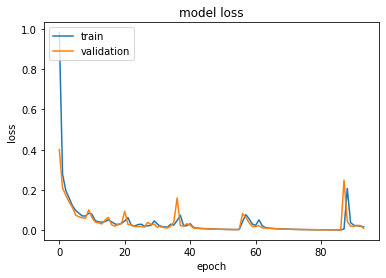

Validation performance
[0.008331581950187683, 1.0]


In [10]:
my_fit(train_x, train_y, test_x, test_y)